# <center> Modeling

In this notebook, we will implement our models, choose metrics, train the models, test them and select the best one

# Import

Note that a recent update create errors on the ```from keras.utils import to_categorical``` import.

In [1]:
import json
import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras

#if error launch => launch a second time
try:
    from keras.utils import to_categorical
except AttributeError as err:
    print('lets do it a second time')
from keras.utils import to_categorical    
print('Done !') 


from tensorflow.python.keras.metrics import Metric
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, AveragePooling2D,Flatten,
                                    Dense, Dropout, Activation)


lets do it a second time
Done !


In [10]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['figure.figsize'] = (12, 10)

# Data Preparation

Data must be formatted before being fed into NN :
1. First, we need to reshape the data, specifiying the size and number of color channels
2. Secondly, we need to convert them into floating point tensors
2. Then, rescale the tensors to values between 0 and 1, as neural networks prefer to deal with small input values.


In [11]:
with open(r'../data/shipsnet.json') as f:
    dataset = json.load(f)

X = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')

In [12]:
y

array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)

In [13]:
X = X.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
X = X / 255
print(X.shape)
#y = to_categorical(y, 2) # if activation ='softmax'

(4000, 80, 80, 3)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.25,
                                                  random_state=42)

In [15]:
print(np.shape(X_train))
print(np.shape(X_val))
print(np.shape(X_test))
print("###############")
print(np.shape(y_train))
print(np.shape(y_val))
print(np.shape(y_test))

(2400, 80, 80, 3)
(800, 80, 80, 3)
(800, 80, 80, 3)
###############
(2400,)
(800,)
(800,)


# Metrics

Here are some first-order suggestions:

     1-Are you predicting probabilities?
        2-Do you need class labels?
            3-Is the positive class more important?
                A=>-Use Precision-Recall AUC
            3-Are both classes important?
                A=>-Use ROC AUC
        2-Do you need probabilities?
            3-Use Brier Score and Brier Skill Score

In [16]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# Setting model parameters

We will use Vincent's Vanhoucke “stretch pants” approach: instead of wasting time looking for the perfect model that perfectly match the problematic, we will just use large parameters that will shrink down to the right size.

In [17]:
EPOCHS = 100

As we use this approach. We have to put mechanisms which will prevent our model from overfitting.

This callback will stop the training when there is no improvement in the loss for 10 consecutive epochs.

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

### Set the correct intial bias

We know the dataset is imbalanced. We need to set the output layer's bias to reflect that. This can help with initial convergence.

* ##### Without

In [99]:
output_bias=None
model = Sequential()
model.add(Flatten(input_shape=[80, 80, 3]))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid',
               bias_initializer=output_bias)) #For a better interpretability

model.compile(loss='binary_crossentropy', optimizer='Adam')

In [100]:
results = model.evaluate(X_train, y_train, verbose=0)
print("Loss: {:0.4f}".format(results))

Loss: 0.8260


* ##### With bias initialization

In [101]:
neg, pos = 3000, 1000
initial_bias = np.log([pos/neg])
output_bias = tf.keras.initializers.Constant(initial_bias)

In [102]:
model = Sequential()
model.add(Flatten(input_shape=[80, 80, 3]))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid',
               bias_initializer=output_bias)) #For a better interpretability

model.compile(loss='binary_crossentropy', optimizer='Adam')
              #metrics=METRICS)

In [103]:
results = model.evaluate(X_train, y_train, verbose=0)
print("Loss: {:0.4f}".format(results))

Loss: 0.5539


The initial loss is about 2 times less than it would have been with naive initialization. with this our model will converge much faster

# Train the model

For the output layer we use the sigmoid function instead of softmax. That's because Softmax is used for multi-classification, whereas Sigmoid is used for binary classification.

In general Softmax is used when ‘n’ number of classes are there. Sigmoid or softmax both can be used for binary (n=2) classification.

Softmax is a generalization of Sigmoid, but as it's binary we will use sigmoid.

Here's two great links for more information :
https://medium.com/arteos-ai/the-differences-between-sigmoid-and-softmax-activation-function-12adee8cf322

https://stackoverflow.com/questions/65258468/activation-functions-softmax-vs-sigmoid

## Fully conncted

In [24]:
model = Sequential()
model.add(Flatten(input_shape=[80, 80, 3]))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid',
               bias_initializer=output_bias)) #For a better interpretability

model.compile(loss='binary_crossentropy', optimizer='Adam',metrics=METRICS)

In [25]:
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    callbacks=[early_stopping],
                    validation_data=(X_val, y_val))

Epoch 1/100
75/75 [==============================] - 7s 40ms/step - loss: 0.7671 - tp: 177.0000 - fp: 195.0000 - tn: 1613.0000 - fn: 415.0000 - accuracy: 0.7458 - precision: 0.4758 - recall: 0.2990 - auc: 0.6648 - prc: 0.3750 - val_loss: 0.3826 - val_tp: 62.0000 - val_fp: 9.0000 - val_tn: 592.0000 - val_fn: 137.0000 - val_accuracy: 0.8175 - val_precision: 0.8732 - val_recall: 0.3116 - val_auc: 0.8989 - val_prc: 0.7571
Epoch 2/100
75/75 [==============================] - 2s 27ms/step - loss: 0.4427 - tp: 311.0000 - fp: 140.0000 - tn: 1668.0000 - fn: 281.0000 - accuracy: 0.8246 - precision: 0.6896 - recall: 0.5253 - auc: 0.8051 - prc: 0.6644 - val_loss: 0.3313 - val_tp: 100.0000 - val_fp: 17.0000 - val_tn: 584.0000 - val_fn: 99.0000 - val_accuracy: 0.8550 - val_precision: 0.8547 - val_recall: 0.5025 - val_auc: 0.9157 - val_prc: 0.7952
Epoch 3/100
75/75 [==============================] - 2s 31ms/step - loss: 0.3356 - tp: 373.0000 - fp: 119.0000 - tn: 1689.0000 - fn: 219.0000 - accuracy: 0

75/75 [==============================] - 3s 34ms/step - loss: 0.1533 - tp: 507.0000 - fp: 59.0000 - tn: 1749.0000 - fn: 85.0000 - accuracy: 0.9400 - precision: 0.8958 - recall: 0.8564 - auc: 0.9782 - prc: 0.9500 - val_loss: 0.2266 - val_tp: 183.0000 - val_fp: 31.0000 - val_tn: 570.0000 - val_fn: 16.0000 - val_accuracy: 0.9413 - val_precision: 0.8551 - val_recall: 0.9196 - val_auc: 0.9708 - val_prc: 0.9299
Epoch 40/100
75/75 [==============================] - 3s 34ms/step - loss: 0.1008 - tp: 532.0000 - fp: 40.0000 - tn: 1768.0000 - fn: 60.0000 - accuracy: 0.9583 - precision: 0.9301 - recall: 0.8986 - auc: 0.9899 - prc: 0.9771 - val_loss: 0.2028 - val_tp: 184.0000 - val_fp: 34.0000 - val_tn: 567.0000 - val_fn: 15.0000 - val_accuracy: 0.9388 - val_precision: 0.8440 - val_recall: 0.9246 - val_auc: 0.9711 - val_prc: 0.9308
Epoch 41/100
75/75 [==============================] - 3s 35ms/step - loss: 0.1417 - tp: 522.0000 - fp: 61.0000 - tn: 1747.0000 - fn: 70.0000 - accuracy: 0.9454 - precisi

75/75 [==============================] - 2s 32ms/step - loss: 0.0715 - tp: 566.0000 - fp: 34.0000 - tn: 1774.0000 - fn: 26.0000 - accuracy: 0.9750 - precision: 0.9433 - recall: 0.9561 - auc: 0.9939 - prc: 0.9850 - val_loss: 0.2772 - val_tp: 168.0000 - val_fp: 26.0000 - val_tn: 575.0000 - val_fn: 31.0000 - val_accuracy: 0.9287 - val_precision: 0.8660 - val_recall: 0.8442 - val_auc: 0.9590 - val_prc: 0.9129
Epoch 78/100
75/75 [==============================] - 2s 31ms/step - loss: 0.1485 - tp: 516.0000 - fp: 51.0000 - tn: 1757.0000 - fn: 76.0000 - accuracy: 0.9471 - precision: 0.9101 - recall: 0.8716 - auc: 0.9793 - prc: 0.9487 - val_loss: 0.1755 - val_tp: 181.0000 - val_fp: 21.0000 - val_tn: 580.0000 - val_fn: 18.0000 - val_accuracy: 0.9513 - val_precision: 0.8960 - val_recall: 0.9095 - val_auc: 0.9760 - val_prc: 0.9430
Epoch 79/100
75/75 [==============================] - 2s 30ms/step - loss: 0.0507 - tp: 574.0000 - fp: 18.0000 - tn: 1790.0000 - fn: 18.0000 - accuracy: 0.9850 - precisi

# Evaluation metrics

* ### plot functions

In [26]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    plt.figure(figsize=(10,10))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()


In [27]:
def plot_cm(labels, predictions,p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [28]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [29]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels,
                                                                  predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')


* ## Evaluation

* * #### Train history

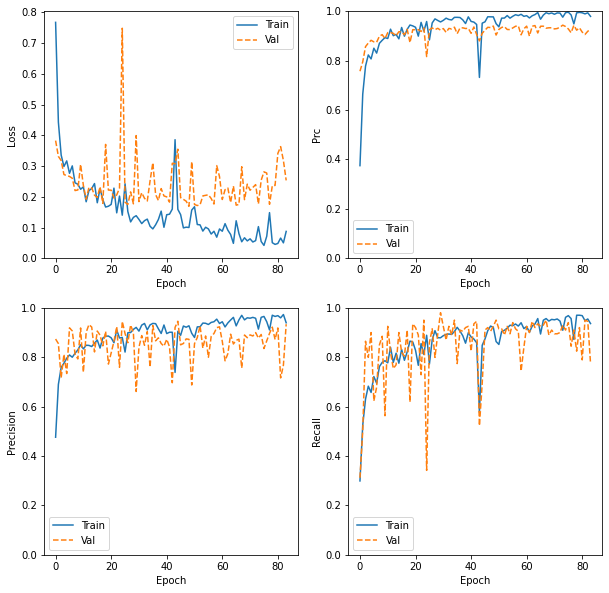

In [30]:
plot_metrics(history)

* * #### Confusion Matrix

In [31]:
train_predictions_baseline = model.predict(X_train)
test_predictions_baseline = model.predict(X_test)

loss :  0.18492278456687927
tp :  190.0
fp :  28.0
tn :  563.0
fn :  19.0
accuracy :  0.9412500262260437
precision :  0.8715596199035645
recall :  0.9090909361839294
auc :  0.973433256149292
prc :  0.9388047456741333



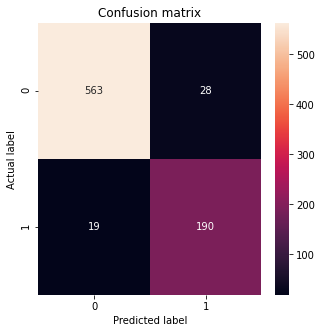

In [32]:
baseline_results = model.evaluate(X_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)


The model could be improved for the __Ship__ class

* * #### ROC Curve

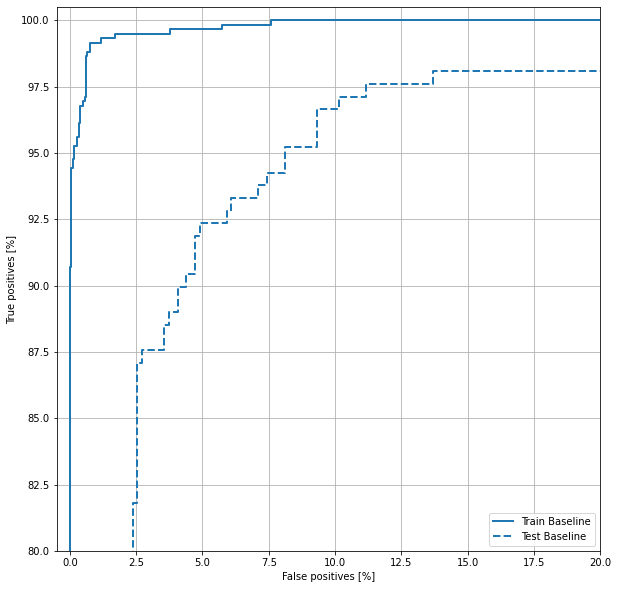

In [33]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

* *  #### AUPRC (precision-recall curve)

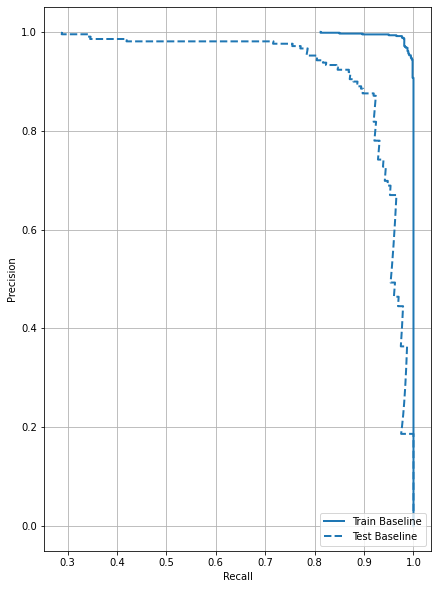

In [34]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

# CNN

In [35]:
# Using a 3x3 kernel and a pooling size of 2x2 at the start of the sequence

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid',
               bias_initializer=output_bias)) #For a better interpretability

model.compile(loss='binary_crossentropy', optimizer='Adam',metrics=METRICS)

In [36]:
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    callbacks=[early_stopping],
                    validation_data=(X_val, y_val))

Epoch 1/100
75/75 [==============================] - 12s 128ms/step - loss: 0.4095 - tp: 457.0000 - fp: 116.0000 - tn: 2283.0000 - fn: 344.0000 - accuracy: 0.8562 - precision: 0.7976 - recall: 0.5705 - auc: 0.8911 - prc: 0.7823 - val_loss: 0.2067 - val_tp: 177.0000 - val_fp: 28.0000 - val_tn: 573.0000 - val_fn: 22.0000 - val_accuracy: 0.9375 - val_precision: 0.8634 - val_recall: 0.8894 - val_auc: 0.9789 - val_prc: 0.9442
Epoch 2/100
75/75 [==============================] - 9s 126ms/step - loss: 0.1788 - tp: 483.0000 - fp: 63.0000 - tn: 1745.0000 - fn: 109.0000 - accuracy: 0.9283 - precision: 0.8846 - recall: 0.8159 - auc: 0.9752 - prc: 0.9325 - val_loss: 0.1624 - val_tp: 184.0000 - val_fp: 38.0000 - val_tn: 563.0000 - val_fn: 15.0000 - val_accuracy: 0.9337 - val_precision: 0.8288 - val_recall: 0.9246 - val_auc: 0.9854 - val_prc: 0.9582
Epoch 3/100
75/75 [==============================] - 9s 122ms/step - loss: 0.1280 - tp: 530.0000 - fp: 50.0000 - tn: 1758.0000 - fn: 62.0000 - accuracy:

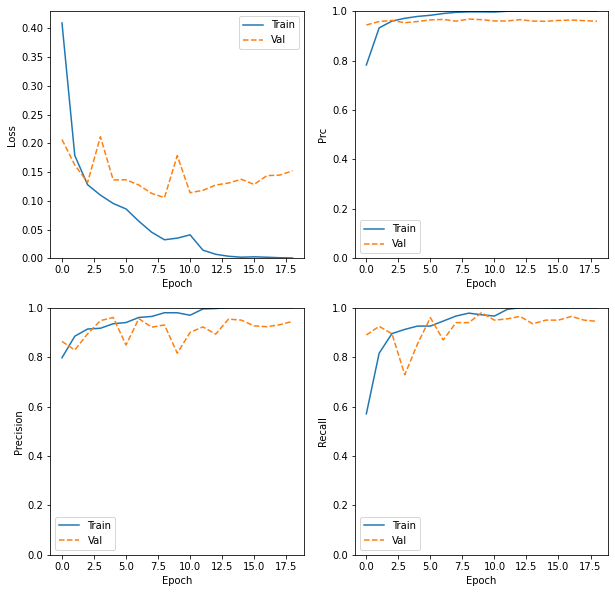

In [37]:
plot_metrics(history)

We see that the best epoch is the 47th, the training ended 10 epochs later.

* * #### Confusion Matrix

In [38]:
train_predictions_baseline = model.predict(X_train)
test_predictions_baseline = model.predict(X_test)

loss :  0.11030959337949753
tp :  196.0
fp :  15.0
tn :  576.0
fn :  13.0
accuracy :  0.9649999737739563
precision :  0.928909957408905
recall :  0.9377990365028381
auc :  0.9855771064758301
prc :  0.9756417274475098



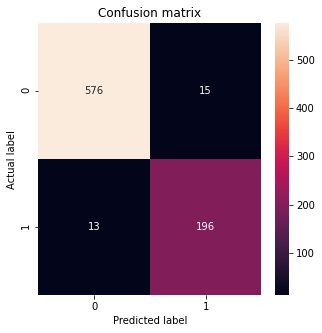

In [39]:
baseline_results = model.evaluate(X_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)


Big improvement on the positive class (__Ship__) prediction

* * #### ROC Curve

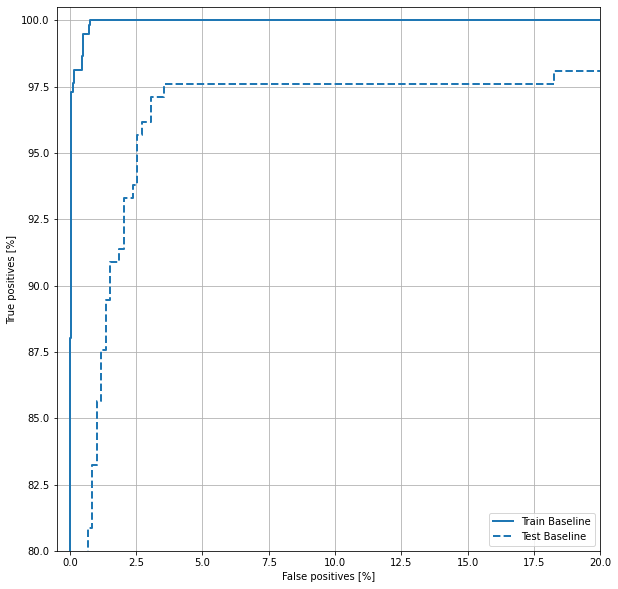

In [40]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

* *  #### AUPRC (precision-recall curve)

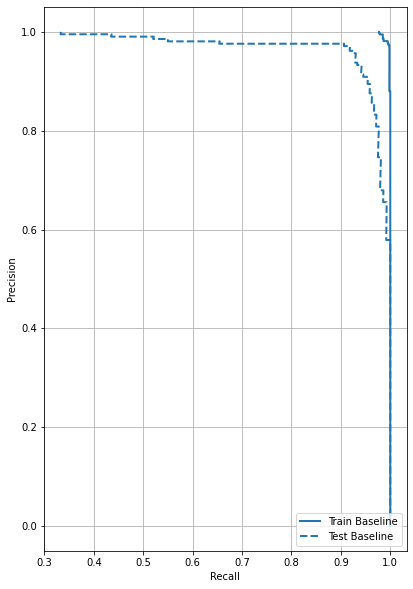

In [41]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

The model has a clear improvement

## Adding a Layer to the CNN

In [42]:
model = Sequential()
model.add(Conv2D(64, (5, 5), input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(32, (3, 3), input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid',
               bias_initializer=output_bias)) #For a better interpretability

model.compile(loss='binary_crossentropy', optimizer='Adam',metrics=METRICS)

In [43]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 76, 76, 64)        4864      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3872)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               387300    
_________________________________________________________________
dense_19 (Dense)             (None, 100)              

In [44]:
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    callbacks=[early_stopping],
                    validation_data=(X_val, y_val))

Epoch 1/100
75/75 [==============================] - 21s 231ms/step - loss: 0.4176 - tp: 438.0000 - fp: 91.0000 - tn: 2308.0000 - fn: 363.0000 - accuracy: 0.8581 - precision: 0.8280 - recall: 0.5468 - auc: 0.8917 - prc: 0.8022 - val_loss: 0.2929 - val_tp: 163.0000 - val_fp: 57.0000 - val_tn: 544.0000 - val_fn: 36.0000 - val_accuracy: 0.8838 - val_precision: 0.7409 - val_recall: 0.8191 - val_auc: 0.9463 - val_prc: 0.8532
Epoch 2/100
75/75 [==============================] - 16s 210ms/step - loss: 0.2504 - tp: 434.0000 - fp: 90.0000 - tn: 1718.0000 - fn: 158.0000 - accuracy: 0.8967 - precision: 0.8282 - recall: 0.7331 - auc: 0.9458 - prc: 0.8722 - val_loss: 0.2407 - val_tp: 146.0000 - val_fp: 20.0000 - val_tn: 581.0000 - val_fn: 53.0000 - val_accuracy: 0.9087 - val_precision: 0.8795 - val_recall: 0.7337 - val_auc: 0.9596 - val_prc: 0.8861
Epoch 3/100
75/75 [==============================] - 15s 194ms/step - loss: 0.1831 - tp: 490.0000 - fp: 80.0000 - tn: 1728.0000 - fn: 102.0000 - accurac

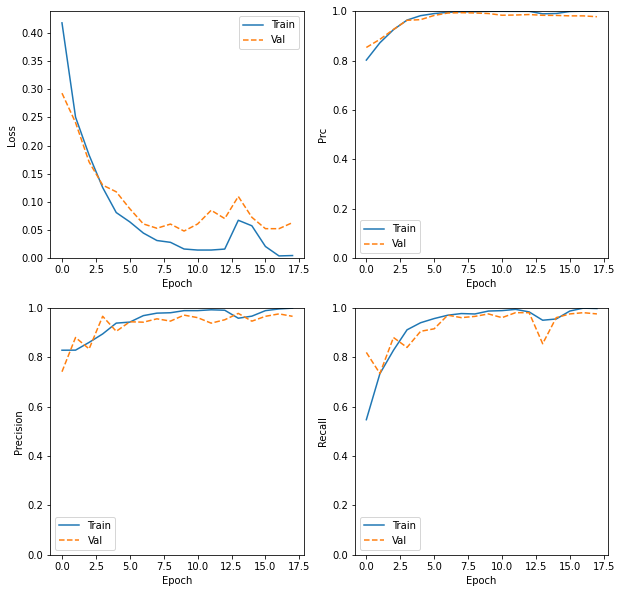

In [45]:
plot_metrics(history)

We see that the best epoch is the 11th, the training ended 10 epochs later.

* * #### Confusion Matrix

In [46]:
train_predictions_baseline = model.predict(X_train)
test_predictions_baseline = model.predict(X_test)

loss :  0.05680212005972862
tp :  202.0
fp :  4.0
tn :  587.0
fn :  7.0
accuracy :  0.9862499833106995
precision :  0.9805825352668762
recall :  0.9665071964263916
auc :  0.9956645965576172
prc :  0.9930094480514526



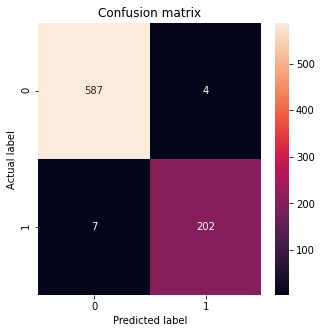

In [47]:
baseline_results = model.evaluate(X_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
    
print()

plot_cm(y_test, test_predictions_baseline)

In [50]:
print("Errors in the positive class",(7/209) * 100,"%")
print("Errors in the negative class",(4/591) * 100,"%")

Errors in the positive class 3.349282296650718 %
Errors in the negative class 0.676818950930626 %


Big improvement on the positive class (__Ship__) prediction. Indeed we only have 3.34% Errors in the ship class

* * #### ROC Curve

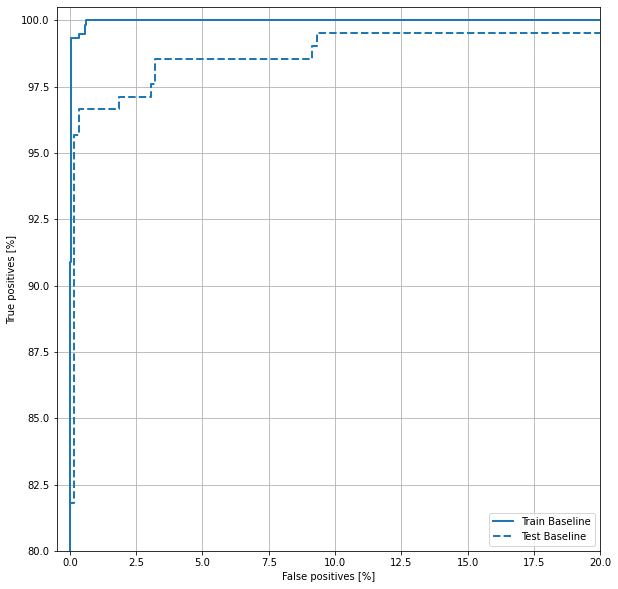

In [51]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

The model converge very quickly to the max of true positive rate. It minimizes the number of false positive errors

* *  #### AUPRC (precision-recall curve)

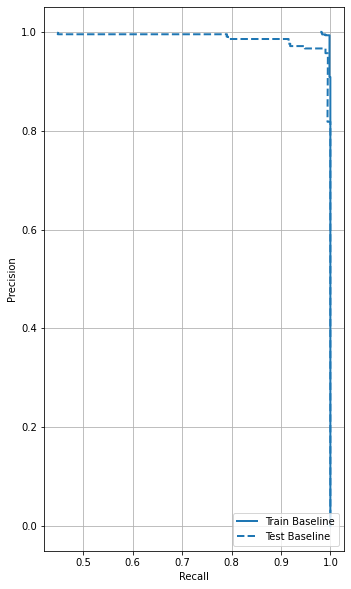

In [52]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

The improvement is clearly present in this chart, we can see that the model can keep a high precision while having a high recall.

This chart is very important. Knowing that the prediction rely on the probability of each class returned by the softmax function. This chart can indicate the prefered tradeoff regarding to our problematic. With it, we can modify the theshold decision function.

For exemple, if we want to detect ships present in protected areas. We probably don't want to miss any ship, so we will prefer the recall against precision. For instance, a model which has only 30% precision as long as it has 99% recall could be a perfect model for this type of situation.

# Errors Exploration

The model has excellent results.

To understand the errors that it made. We will explore the images misclassified

In [64]:
df = pd.DataFrame(test_predictions_baseline, columns=["probability"])
df['labels'] = y_test
df

,probability,labels
0,9.997113e-01,1
1,3.442231e-12,0
2,9.996434e-01,1
3,1.657290e-01,0
4,9.440900e-17,0
...,...,...
795,6.867456e-01,0
796,9.987829e-01,1
797,1.159072e-03,0
798,6.708580e-11,0


In [66]:
# Print the images missclassified as not ship
df_erros = df[(df.probability<0.5) & (df.labels == 1)]

In [67]:
df_erros

,probability,labels
47,0.012253,1
81,0.000014,1
365,0.105730,1
518,0.093899,1
537,0.011027,1
562,0.149344,1
708,0.210032,1


In [74]:
df_e1=pd.DataFrame(columns=['data','labels'])

my_list = map(lambda x: x[:], X_test[df_erros.index.values])
ser = pd.Series(my_list)
df_e1.data = pd.Series(ser)

#my_list = map(lambda x: x[:], y_test[df_erros.index.values])
ser = pd.Series(y_test[df_erros.index.values])
df_e1.labels = pd.Series(ser)

In [75]:
df_e1

,data,labels
0,"[[[0.3058823529411765, 0.43137254901960786, 0....",1
1,"[[[0.09803921568627451, 0.12549019607843137, 0...",1
2,"[[[0.1568627450980392, 0.24313725490196078, 0....",1
3,"[[[0.30980392156862746, 0.3568627450980392, 0....",1
4,"[[[0.7254901960784313, 0.7215686274509804, 0.6...",1
5,"[[[0.20784313725490197, 0.2823529411764706, 0....",1
6,"[[[0.25882352941176473, 0.28627450980392155, 0...",1


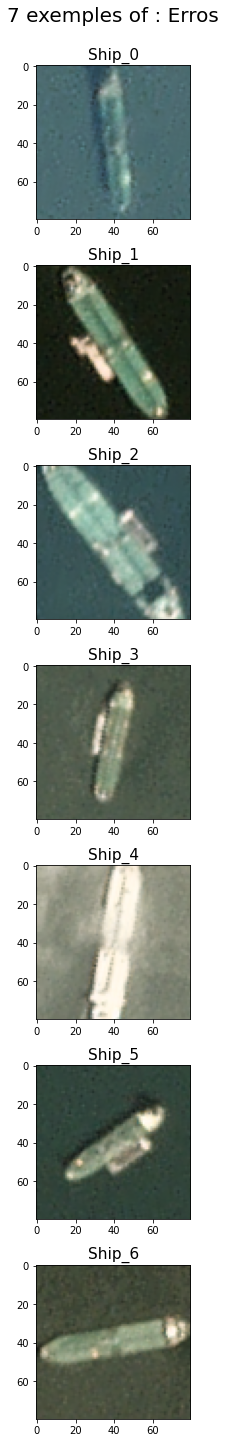

In [77]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../scripts/')

import functions as f

f.show_examples(classes= {0:'No_ship',1:'Ship'},
              images= df_e1.data, #X
              labels= df_e1.labels, #y
              set_name= 'Erros',
             nbr_images=7)

We clearly see that these images are in fact ships that where misslabeled as not ships.

So the 7 remaining errors are not errors.

So in fact, our model don't have False positives.

We need to relabel the images

In [79]:
# Print the images missclassified as ship
df_erros2 = df[(df.probability>=0.5) & (df.labels == 0)]

In [80]:
df_erros2

,probability,labels
441,0.541111,0
564,0.561842,0
628,0.968453,0
795,0.686746,0


In [81]:
df_e2=pd.DataFrame(columns=['data','labels'])

my_list = map(lambda x: x[:], X_test[df_erros2.index.values])
ser = pd.Series(my_list)
df_e2.data = pd.Series(ser)

#my_list = map(lambda x: x[0], y_test[df_erros2.index.values])
ser = pd.Series(y_test[df_erros2.index.values])
df_e2.labels = pd.Series(ser)

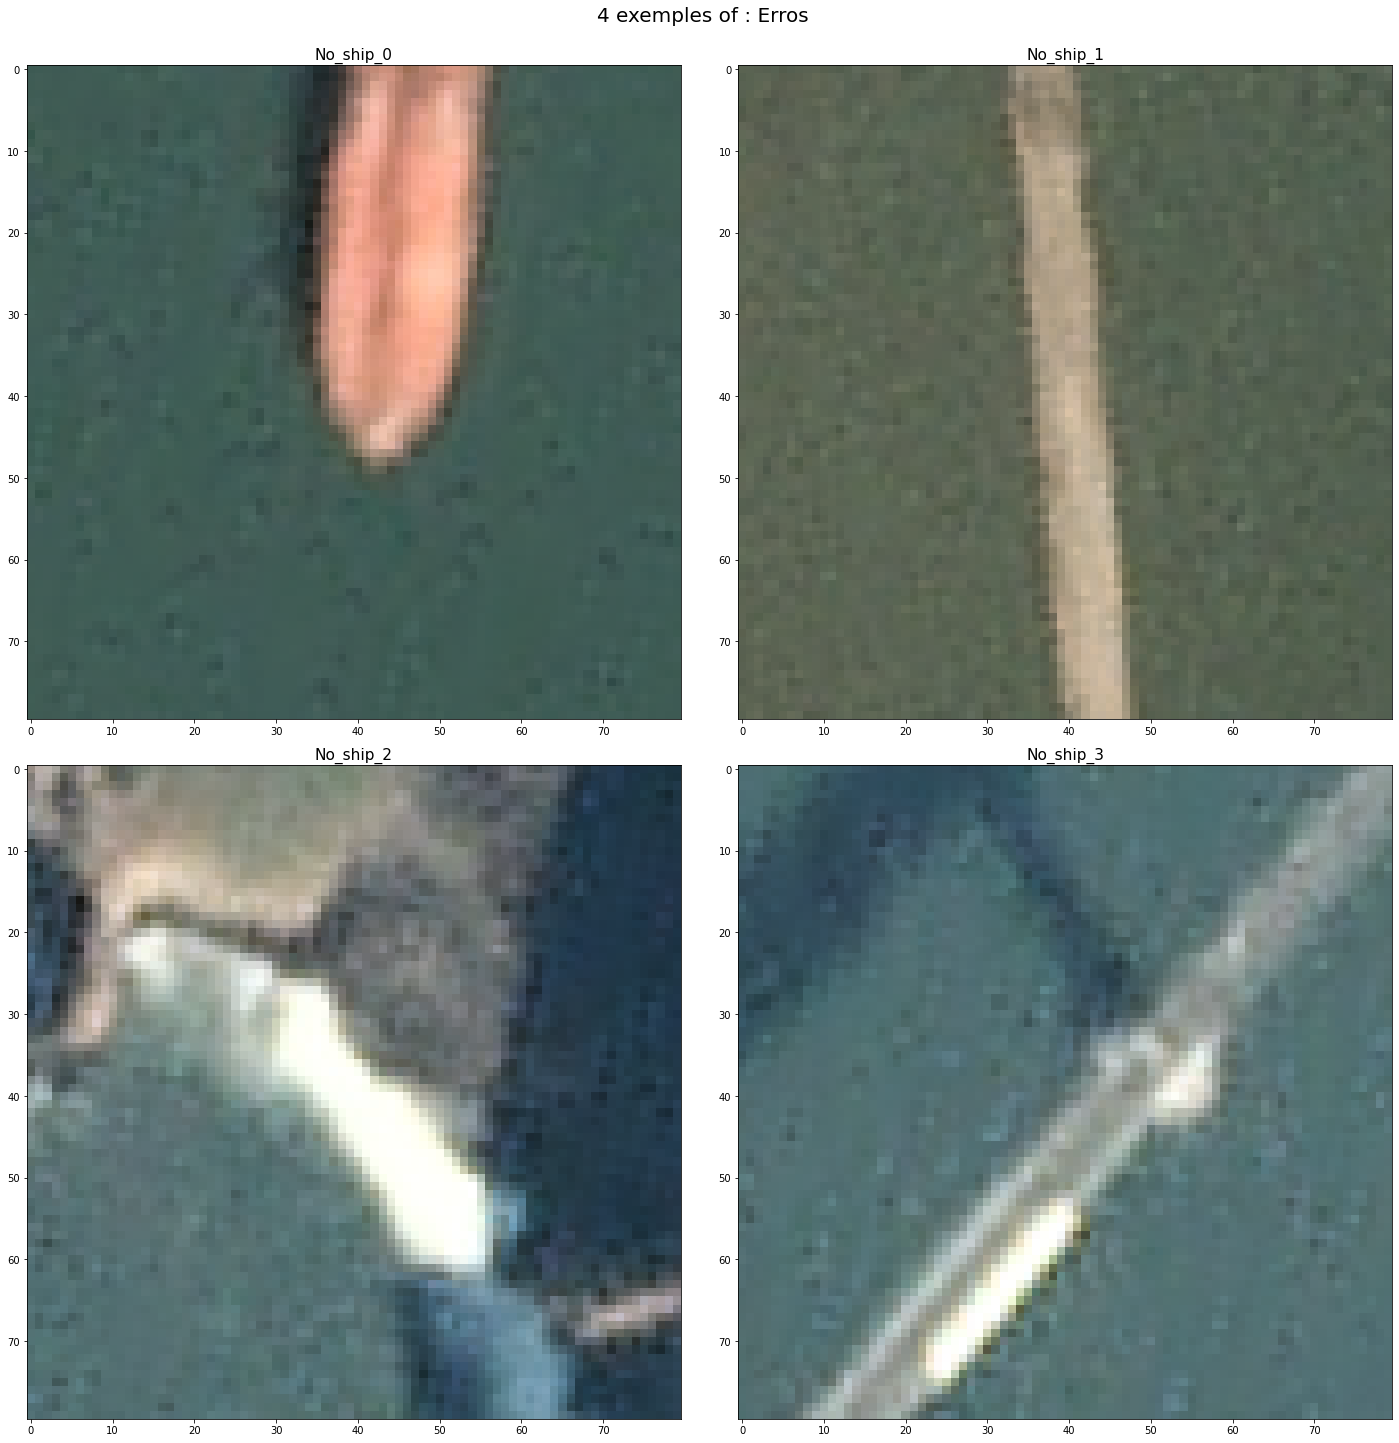

In [82]:
f.show_examples(classes= {0:'No_ship',1:'Ship'},
              images= df_e2.data, #X
              labels= df_e2.labels, #y
              set_name= 'Erros',
             nbr_images=4)

As we noticed in the EDA, bridges and partial errors could lead the model to erros.

It encompasses 3/4 of the errors

# Save Model

In [83]:
import time
ts = time.time()
ts = str(int(ts))

model.save('../models/CNN_FINAL.h5')